In [1]:
import sys
from pathlib import Path

project_root = Path().cwd().parent.resolve().parent / 'src' / 'nanoCocoa_aiserver'
sys.path.insert(0, str(project_root))

print(str(project_root))

/home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver


In [2]:

import helper_plot_hangul
import importlib
import gc
import logging
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.patches import Rectangle
from typing import List, Optional, Tuple, Dict, Any
from helper_plot_hangul import matplotlib_font_reset, matplotlib_font_get
from helper_dev_utils import *
from diffusers.utils import load_image
print(matplotlib_font_get())


2026-01-04 12:58:45 W [helper_utils_colab:211] - GoogleDrive not found, falling back to temp folder: /tmp
2026-01-04 12:58:45 W [helper_utils_colab:122] - Cache directory not found, falling back to temp folder: /tmp


/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'font_family': 'NanumGothic', 'font_path': '/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/helper_plot_hangul/fonts/NanumGothic.ttf'}


In [3]:
import os
import logging
import torch
import logging
from helper_dev_utils import get_auto_logger
# ==========================================
# 설정 & 상수 (Configuration)
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16

# 모델 ID 정의
MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

# 예상 소요 시간 (초 단위, 초기값)
ESTIMATED_TIMES = {
    "init": 30,
    "stage_a": 300,  # 배경 생성 및 합성
    "stage_b": 200,  # 텍스트 자산 생성
    "stage_c": 90,   # 최종 합성 (Flux Inpainting 추가: 28 steps ≈ 30초)
}
TOTAL_ESTIMATED_TIME = sum(ESTIMATED_TIMES.values())

# 로깅 설정
logger = get_auto_logger()



In [4]:
import torch
import warnings
from PIL import Image
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from config import DEVICE
from utils import flush_gpu

# timm 라이브러리 deprecation 경고 억제
warnings.filterwarnings("ignore", category=FutureWarning, module="timm")

class SegmentationModel:
    """
    BiRefNet을 사용하여 이미지 세그멘테이션(배경 제거)을 수행하는 클래스입니다.
    """
    def __init__(self):
        self.device = DEVICE

    def run(self, image: Image.Image) -> tuple[Image.Image, Image.Image]:
        """
        이미지의 배경을 제거합니다.
        
        Args:
            image (Image.Image): 입력 이미지
            
        Returns:
            tuple[Image.Image, Image.Image]: (배경 제거된 이미지, 마스크)
        """
        logger.debug("[Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)")
        flush_gpu()
        
        model = AutoModelForImageSegmentation.from_pretrained(
            MODEL_IDS["SEG"], trust_remote_code=True
        ).to(self.device).eval()

        W, H = image.size
        # 고해상도 처리를 위해 리사이즈 (필요 시 조정 가능)
        img_resized = image.resize((1024, 1024), Image.LANCZOS)
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        input_tensor = transform(img_resized).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            preds = model(input_tensor)[-1].sigmoid().cpu()
        
        pred = preds[0].squeeze()
        mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
        
        # 마스크 이진화 (Thresholding)
        mask = mask.point(lambda x: 255 if x > 128 else 0)
        
        result = image.copy()
        result.putalpha(mask)
        
        # 리소스 정리
        del model, input_tensor
        flush_gpu()
        
        return result, mask

segmenter = SegmentationModel()
logger.debug("로딩 성공")

2026-01-04 12:58:50 D [ipykernel_launcher:66] - 로딩 성공


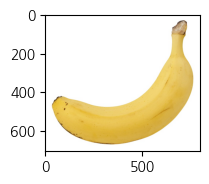

In [5]:
image_png = load_image("image.png").convert("RGB")
plt.figure(figsize=(2, 2))
plt.imshow(image_png)

In [6]:
if "segmenter" in globals():
    del segmenter
    segmenter = None
    segmenter = SegmentationModel()
flush_gpu()

sm_result, sm_mask = segmenter.run(image_png)
# 저장
sm_result.save("image_result.png")
sm_mask.save("image_mask.png")

2026-01-04 12:58:51 D [ipykernel_launcher:29] - [Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)


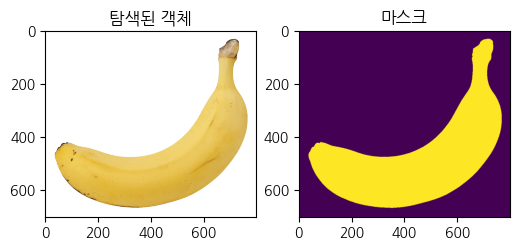

In [7]:
plt.figure(figsize=(6, 3))
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(sm_result)
ax1.set_title("탐색된 객체")

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(sm_mask)
ax2.set_title("마스크")
plt.show()

In [8]:

import torch
import gc
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
from diffusers import (
    FluxPipeline,
    FluxImg2ImgPipeline,
    FluxInpaintPipeline,
    FluxTransformer2DModel
)
from transformers import BitsAndBytesConfig
from config import TORCH_DTYPE, logger
from utils import flush_gpu

class FluxGenerator:
    """
    FLUX 모델을 사용하여 배경 생성, 이미지 리파인, 지능형 합성을 수행하는 클래스입니다.
    """
    
    def __init__(self):
        self._prompt = []
        self._negative = []

    def base_prompt(
        self,
        prompt: list[str],
        negative: list[str],
    ) -> None:
        self._prompt = prompt
        self._negative = negative

    
    def position_analysis(
        self,
        background: Image.Image,
        threshold_percentile: int = 40,
        min_area: float = 0.15
    ) -> tuple:
        """
        MaskGenerator.recommend_position()의 분석 과정을 시각화하여 이미지로 반환합니다.

        Args:
            background: 분석할 배경 이미지
            threshold_percentile: 밝기 임계값 (기본 40)
            min_area: 최소 면적 비율

        Returns:
            tuple: (추천 위치, scores 딕셔너리, 분석 이미지 dict)
                  images = {
                      'original': 원본 이미지,
                      'regions': 3개 영역 구분 오버레이,
                      'binary_mask': 이진 마스크,
                      'edges': 엣지 검출,
                      'histogram': 밝기 히스토그램,
                      'bar_chart': 점수 비교 바 차트
                  }
        """
        # 1. 동일한 알고리즘으로 위치 계산
        w, h = background.size
        bg_gray = background.convert("L")
        bg_arr = np.array(bg_gray)
        threshold = np.percentile(bg_arr, threshold_percentile)
        mask_arr = (bg_arr < threshold)  # True for dark areas (empty space)
        
        # 영역별 여백 점수 계산
        top_area = mask_arr[0:int(h*0.33), :].sum()
        center_area = mask_arr[int(h*0.33):int(h*0.66), :].sum()
        bottom_area = mask_arr[int(h*0.66):h, :].sum()
        
        scores = {
            "top": int(top_area),
            "center": int(center_area),
            "bottom": int(bottom_area)
        }
        
        # 최적 위치 결정
        best_position = max(scores, key=scores.get)
        total_pixels = w * h
        if scores[best_position] / (total_pixels / 3) < min_area:
            best_position = "top"
        
        # 2. 시각화 이미지 생성
        images = {}
        
        # 이미지 1: 원본 이미지 (제목 추가)
        img_original = background.copy()
        draw = ImageDraw.Draw(img_original)
        try:
            font_large = ImageFont.truetype(matplotlib_font_get()['font_path'], 40)
        except:
            font_large = ImageFont.load_default()
            
        draw.text((w//2, 30), f'추천 위치: {best_position}', fill='yellow', 
                 anchor='mm', font=font_large, stroke_width=2, stroke_fill='black')
        images['original'] = img_original
        
        # 이미지 2: 3개 영역 구분 오버레이
        overlay = np.array(background.convert("RGB")).copy()
        region_height = int(h * 0.33)
        
        # 상단 (빨강), 중앙 (초록), 하단 (파랑)
        overlay[0:region_height, :, 0] = np.clip(overlay[0:region_height, :, 0] + 80, 0, 255)
        overlay[region_height:region_height*2, :, 1] = np.clip(overlay[region_height:region_height*2, :, 1] + 80, 0, 255)
        overlay[region_height*2:h, :, 2] = np.clip(overlay[region_height*2:h, :, 2] + 80, 0, 255)
        
        img_regions = Image.fromarray(overlay)
        draw = ImageDraw.Draw(img_regions)
        try:
            font_med = ImageFont.truetype(matplotlib_font_get()['font_path'], 30)
        except:
            font_med = ImageFont.load_default()
        
        draw.text((w//2, region_height//2), f'상단\n점수: {scores["top"]:,}', 
                 fill='white', anchor='mm', font=font_med, stroke_width=2, stroke_fill='red')
        draw.text((w//2, region_height + region_height//2), f'중앙\n점수: {scores["center"]:,}', 
                 fill='white', anchor='mm', font=font_med, stroke_width=2, stroke_fill='green')
        draw.text((w//2, region_height*2 + (h - region_height*2)//2), f'하단\n점수: {scores["bottom"]:,}', 
                 fill='white', anchor='mm', font=font_med, stroke_width=2, stroke_fill='blue')
        images['regions'] = img_regions
        
        # 이미지 3: 이진 마스크
        img_mask = Image.fromarray((mask_arr * 255).astype(np.uint8), mode='L')
        images['binary_mask'] = img_mask
        
        # 이미지 4: 엣지 검출
        bg_gray_np = np.array(bg_gray)
        edges = cv2.Canny(bg_gray_np, 100, 200)
        img_edges = Image.fromarray(edges, mode='L')
        images['edges'] = img_edges
        
        # image_canny = np.array(background)
        # image_canny = cv2.Canny(image_canny, 50, 150) 
        # image_canny = image_canny[:, :, None]
        # image_canny = np.concatenate([image_canny, image_canny, image_canny], axis=2)
        # images['canny_edges'] = Image.fromarray(image_canny)
        
        # 이미지 5: 밝기 히스토그램 (matplotlib -> PIL)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.hist(bg_arr.flatten(), bins=256, range=(0, 256), color='gray', alpha=0.7)
        ax.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'임계값: {threshold:.1f}')
        ax.set_title('밝기 분포 히스토그램', fontsize=14)
        ax.set_xlabel('밝기 값 (0-255)', fontsize=11)
        ax.set_ylabel('픽셀 수', fontsize=11)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', dpi=100)
        buf.seek(0)
        img_histogram = Image.open(buf).copy()
        plt.close(fig)
        images['histogram'] = img_histogram
        
        # 이미지 6: 점수 비교 바 차트 (matplotlib -> PIL)
        fig, ax = plt.subplots(figsize=(8, 6))
        positions = list(scores.keys())
        values = list(scores.values())
        colors = ['red' if p == best_position else 'lightgray' for p in positions]
        bars = ax.bar(positions, values, color=colors, alpha=0.8)
        
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:,}',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        ax.set_title('영역별 점수 비교', fontsize=14)
        ax.set_xlabel('위치', fontsize=11)
        ax.set_ylabel('어두운 픽셀 수', fontsize=11)
        ax.grid(True, alpha=0.3, axis='y')
        
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', dpi=100)
        buf.seek(0)
        img_barchart = Image.open(buf).copy()
        plt.close(fig)
        images['bar_chart'] = img_barchart
        
        return best_position, scores, images
    
    def generate_background(self, prompt: str, negative_prompt: str = None, guidance_scale: float = 3.5, seed: int = None, num_steps=25, progress_callback=None) -> Image.Image:
        """
        텍스트 프롬프트를 기반으로 배경 이미지를 생성합니다.
        
        Args:
            prompt (str): 배경 생성 프롬프트
            negative_prompt (str, optional): 배제할 요소들에 대한 부정 프롬프트
            guidance_scale (float): 프롬프트 준수 강도
            seed (int, optional): 난수 시드
            progress_callback (callable, optional): 진행률 콜백 함수
            
        Returns:
            Image.Image: 생성된 이미지
        """
        logger.debug("[Engine] Loading FLUX (Text-to-Image)... (FLUX 텍스트-이미지 모델 로딩 중)")
        flush_gpu()
        
        _prompt = " ".join([prompt] + self._prompt) if prompt else " ".join(self._prompt)
        _negative = " ".join([negative_prompt] + self._negative) if negative_prompt else " ".join(self._negative)
        
        quant_config = BitsAndBytesConfig(load_in_4bit=True)
        transformer = FluxTransformer2DModel.from_pretrained(
            MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
        )
        pipe = FluxPipeline.from_pretrained(
            MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
        )
        pipe.enable_model_cpu_offload()

        generator = None
        if seed is not None:
             generator = torch.Generator("cpu").manual_seed(seed)
        else:
             generator = torch.Generator("cpu").manual_seed(42)

        def callback_fn(pipe_obj, step_index, timestep, callback_kwargs):
            logger.debug(f"[FluxGenerator] {step_index}/{num_steps} {timestep}")
            if progress_callback:
                progress_callback(step_index + 1, num_steps, "flux_bg_generation")
            return callback_kwargs
        
        logger.debug(f"[FluxGenerator] {_prompt}")
        logger.debug(f"[FluxGenerator] {_negative}")
        image = pipe(
            prompt=_prompt, 
            negative_prompt=_negative, 
            height=1024, width=1024, 
            num_inference_steps=num_steps,
            guidance_scale=guidance_scale,
            generator=generator,
            callback_on_step_end=callback_fn if progress_callback else None
        ).images[0]
        
        del pipe, transformer
        flush_gpu()
        return image

    def refine_image(self, draft_image: Image.Image, prompt: str = None, negative_prompt: str = None, strength: float = 0.6, guidance_scale: float = 3.5, seed: int = None, progress_callback=None) -> Image.Image:
        """
        이미지를 리터칭(Img2Img, 배경 합성)하여 품질을 높입니다.
        
        Args:
            draft_image (Image.Image): 초안 이미지
            prompt (str): 배경 합성 프롬프트 (없을 경우 기본값 사용)
            negative_prompt (str): 배경 합성 부정 프롬프트 (없을 경우 기본값 사용)
            strength (float): 변환 강도
            guidance_scale (float): 프롬프트 준수 강도
            seed (int, optional): 난수 시드
            progress_callback (callable, optional): 진행률 콜백 함수
            
        Returns:
            Image.Image: 리터칭된 배경 합성 이미지
        """
        logger.debug("[Engine] Loading FLUX (Img-to-Img for Background Composition)... (FLUX 배경 합성 모델 로딩 중)")
        flush_gpu()
        
        quant_config = BitsAndBytesConfig(load_in_8bit=True)
        transformer = FluxTransformer2DModel.from_pretrained(
            MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
        )
        pipe = FluxImg2ImgPipeline.from_pretrained(
            MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
        )
        pipe.enable_model_cpu_offload()

        _prompt = " ".join([prompt] + self._prompt) if prompt else " ".join(self._prompt)
        _negative = " ".join([negative_prompt] + self._negative) if negative_prompt else " ".join(self._negative)

        generator = None
        if seed is not None:
             generator = torch.Generator("cpu").manual_seed(seed)
        else:
             generator = torch.Generator("cpu").manual_seed(42)

        num_steps = 30
        
        def callback_fn(pipe_obj, step_index, timestep, callback_kwargs):
            if progress_callback:
                progress_callback(step_index + 1, num_steps, "flux_bg_composition_refinement")
            return callback_kwargs

        refined_image = pipe(
            prompt=_prompt,
            negative_prompt=_negative,
            height=1024, width=1024,
            image=draft_image, 
            strength=strength, 
            num_inference_steps=num_steps, 
            guidance_scale=guidance_scale,
            generator=generator,
            callback_on_step_end=callback_fn if progress_callback else None
        ).images[0]

        del pipe, transformer
        flush_gpu()
        return refined_image

    def dilate_mask(self, mask: Image.Image, kernel_size: int) -> Image.Image:
        """
        마스크를 확장(Dilation)하여 페더링 효과와 그림자 생성 영역을 확보합니다.
        
        Args:
            mask (Image.Image): 원본 마스크
            kernel_size (int): 커널 크기 (확장 범위)
            
        Returns:
            Image.Image: 확장된 마스크
        """
        if kernel_size <= 0:
            return mask
            
        mask_np = np.array(mask)
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        dilated = cv2.dilate(mask_np, kernel, iterations=1)
        return Image.fromarray(dilated)

    def build_injection_prompt(self, background_prompt: str, product_description: str) -> str:
        """
        배경 프롬프트와 상품 설명을 조합하여 주입용 프롬프트를 생성합니다.
        """
        # 간단한 결합. 필요시 복잡한 로직 추가 가능
        return f"{background_prompt}, {product_description}"

    def extend_negative_prompt(self, negative_prompt: str) -> str:
        """
        기존 부정 프롬프트를 확장합니다.
        """
        return negative_prompt if negative_prompt else ""

    def prepare_inpaint_inputs(
        self,
        background: Image.Image,
        product_foreground: Image.Image,
        product_mask: Image.Image,
        bbox: Tuple[int, int, int, int],
        mask_dilation: int = 0,
        padding_ratio: float = 0.85
    ) -> Tuple[Image.Image, Image.Image]:
        """
        Inpainting을 위한 입력 준비: 리사이즈, 배치, 마스크 생성
        
        Args:
            background: 배경 이미지
            product_foreground: 상품 이미지 (RGBA)
            product_mask: 상품 마스크 (L)
            bbox: 배치 영역 (x1, y1, x2, y2) 픽셀 좌표
            mask_dilation: 마스크 확장 크기
            padding_ratio: bbox 대비 객체 크기 비율
            
        Returns:
            Tuple[Image.Image, Image.Image]: (draft_rgb, full_mask)
        """
        x1, y1, x2, y2 = bbox
        bbox_w, bbox_h = x2 - x1, y2 - y1
        
        obj_w, obj_h = product_foreground.size
        target_w = int(bbox_w * padding_ratio)
        target_h = int(bbox_h * padding_ratio)
        scale = min(target_w / obj_w, target_h / obj_h)
        new_w, new_h = int(obj_w * scale), int(obj_h * scale)
        
        resized_fg = product_foreground.resize((new_w, new_h), Image.LANCZOS)
        resized_mask = product_mask.resize((new_w, new_h), Image.LANCZOS)
        
        center_x = x1 + (bbox_w - new_w) // 2
        center_y = y1 + (bbox_h - new_h) // 2
        
        logger.debug(f"[FluxGenerator] Resized: {obj_w}x{obj_h} → {new_w}x{new_h}, Position: ({center_x}, {center_y})")
        
        draft = background.copy().convert("RGBA")
        draft.paste(resized_fg, (center_x, center_y), resized_fg)
        draft_rgb = draft.convert("RGB")
        
        if mask_dilation != 0:
            action = "Dilating" if mask_dilation > 0 else "Eroding"
            logger.debug(f"[FluxGenerator] {action} mask by {abs(mask_dilation)}px")
            final_mask_resized = self.dilate_mask(resized_mask, mask_dilation)
        else:
            final_mask_resized = resized_mask
        
        full_mask = Image.new("L", background.size, 0)
        full_mask.paste(final_mask_resized, (center_x, center_y))
        
        return draft_rgb, full_mask

    def inject_features_via_inpaint(
        self,
        image,
        mask_image,
        prompt: str,
        negative_prompt: str = None,
        strength: float = 0.5,
        guidance_scale: float = 3.5,
        num_inference_steps: int = 28,
        seed: int = None,
        progress_callback=None
    ) -> Image.Image:
        """
        Flux Inpainting으로 상품 특성 주입
        
        Args:
            bbox: 배치 영역 (x1, y1, x2, y2) 픽셀 좌표
            padding_ratio: bbox 대비 객체 크기 비율
        """
        logger.info("[FluxGenerator] Loading FLUX Inpainting...")
        flush_gpu()
        
        quant_config = BitsAndBytesConfig(load_in_8bit=True)
        transformer = FluxTransformer2DModel.from_pretrained(
            MODEL_IDS["FLUX"], subfolder="transformer",
            quantization_config=quant_config, torch_dtype=TORCH_DTYPE
        )
        pipe = FluxInpaintPipeline.from_pretrained(
            MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
        )
        pipe.enable_model_cpu_offload()
        
        generator = torch.Generator("cpu").manual_seed(seed if seed else 42)
        
        def callback_fn(pipe_obj, step_index, timestep, callback_kwargs):
            if progress_callback:
                progress_callback(step_index + 1, num_inference_steps, "flux_feature_injection")
            return callback_kwargs
        
        _prompt = " ".join([prompt] + self._prompt) if prompt else " ".join(self._prompt)
        _negative = " ".join([negative_prompt] + self._negative) if negative_prompt else " ".join(self._negative)
        
        if not mask_image or mask_image is None:
            mask_image = Image.new("L", image.size, 255)
        
        logger.info(f"[FluxGenerator] _promp='{_prompt}'")
        logger.info(f"[FluxGenerator] _negative='{_negative}'")
        logger.info(f"[FluxGenerator] strength={strength}, steps={num_inference_steps}")
        
        result = pipe(
            prompt=_prompt,
            negative_prompt=_negative,
            height=1024, width=1024,
            image=image,
            mask_image=mask_image,
            strength=strength,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=generator,
            callback_on_step_end=callback_fn if progress_callback else None
        ).images[0]
        
        logger.info("[FluxGenerator] Feature injection completed")
        
        del pipe, transformer, quant_config
        
        flush_gpu()
        
        return result


    def inpaint_composite(
        self,
        background: Image.Image,
        text_asset: Image.Image,
        mask: Image.Image,
        prompt: str,
        negative_prompt: str = None,
        strength: float = 0.4,
        guidance_scale: float = 3.5,
        num_inference_steps: int = 28,
        mask_dilation: int = 0,
        seed: int = None,
        progress_callback=None
    ) -> Image.Image:
        """
        Flux Inpainting을 사용하여 텍스트를 배경과 맥락적으로 합성합니다.
        
        Args:
            background (Image.Image): 배경 이미지
            text_asset (Image.Image): 텍스트 에셋 (RGBA)
            mask (Image.Image): 합성 영역 마스크 (255=인페인팅, 0=보존)
            prompt (str): 합성 프롬프트
            strength (float): 변환 강도 (0.0~1.0)
            guidance_scale (float): 프롬프트 준수 강도
            num_inference_steps (int): 추론 스텝 수 (품질 우선: 28~50)
            seed (int, optional): 난수 시드
            progress_callback (callable, optional): 진행률 콜백
            
        Returns:
            Image.Image: 합성된 최종 이미지
        """
        logger.info("[FluxGenerator] Loading FLUX Inpainting for composition...")
        flush_gpu()
        
        # Flux Inpainting 파이프라인 로드
        quant_config = BitsAndBytesConfig(load_in_8bit=True)
        transformer = FluxTransformer2DModel.from_pretrained(
            MODEL_IDS["FLUX"], 
            subfolder="transformer", 
            quantization_config=quant_config, 
            torch_dtype=TORCH_DTYPE
        )
        pipe = FluxInpaintPipeline.from_pretrained(
            MODEL_IDS["FLUX"], 
            transformer=transformer, 
            torch_dtype=TORCH_DTYPE
        )
        pipe.enable_model_cpu_offload()
        
        # 초안 합성 (텍스트를 배경에 배치)
        draft = background.copy().convert("RGBA")
        text_resized = text_asset.resize(draft.size, Image.LANCZOS)
        draft.paste(text_resized, (0, 0), text_resized)
        draft_rgb = draft.convert("RGB")
        
        # 마스크 확장 (그림자 영역 확보)
        if mask_dilation > 0:
            logger.info(f"[FluxGenerator] Dilating mask by {mask_dilation} pixels for natural shadows...")
            final_mask = self.dilate_mask(product_mask, mask_dilation)
        else:
            final_mask = product_mask
        
        # Generator 설정
        generator = None
        if seed is not None:
            generator = torch.Generator("cpu").manual_seed(seed)
        else:
            generator = torch.Generator("cpu").manual_seed(42)
        
        # Progress callback
        def callback_fn(pipe_obj, step_index, timestep, callback_kwargs):
            if progress_callback:
                progress_callback(step_index + 1, num_inference_steps, "flux_inpaint_composite")
            return callback_kwargs
        
        
        _prompt = " ".join([prompt] + self._prompt) if prompt else " ".join(self._prompt)
        _negative = " ".join([negative_prompt] + self._negative) if negative_prompt else " ".join(self._negative)
        
        
        logger.info(f"[FluxGenerator] Running inpainting: prompt='{prompt[:50]}...', steps={num_inference_steps}")
        
        # Inpainting 실행
        result = pipe(
            prompt=_prompt,
            negative_prompt=_negative,
            height=1024, width=1024,
            image=draft_rgb,
            mask_image=mask,
            strength=strength,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=generator,
            callback_on_step_end=callback_fn if progress_callback else None
        ).images[0]
        
        logger.info("[FluxGenerator] Inpainting composition completed")
        
        del pipe, transformer
        flush_gpu()
        
        return result

flux_gen = FluxGenerator()
logger.debug("로딩 성공")

2026-01-04 12:59:02 D [config:564] - 로딩 성공


In [9]:
num_steps = 14

def progress_callback(step, total, sub_step_name):
    logger.debug(f"[Test Progress] {sub_step_name}: {step}/{total}")


In [10]:

# 공통 배경 요소 정의
# 공통 배경 요소
background_scene = "A cinematic photograph of an aged, empty wooden farm table resting in a sunlit room. Shafts of warm sunlight stream across the rough tabletop, revealing dust motes and deep textures. The wood is weathered and dark."
# → 영화적인 분위기의 사진, 햇살이 들어오는 방 안에 놓인 오래된 나무 농가 테이블
# → 따뜻한 햇살이 거친 테이블 표면을 가로질러 비추며 먼지 입자와 깊은 질감을 드러냄
# → 오래되어 바래고 어두운 색을 띠는 나무

background_style = "Shallow depth of field, highly detailed, rustic atmosphere, photorealistic, 8k."
# → 얕은 심도(배경 흐림, 테이블에 초점), 매우 디테일한 표현
# → 소박하고 시골스러운 분위기, 사진처럼 사실적인 표현
# → 초고해상도 8K 품질

# 공통 부정 요소
common_negative = "blurry, low quality, artificial, plastic, oversaturated, bad lighting"
# → 흐릿한, 저화질, 인위적인, 플라스틱 같은 질감
# → 과도하게 채도가 높은, 조명이 나쁜 표현은 배제

flux_gen.base_prompt(
    prompt=[
        background_scene,
        background_style
    ],
    negative=[
        common_negative
    ]
)


2026-01-04 12:59:02 D [config:198] - [Engine] Loading FLUX (Text-to-Image)... (FLUX 텍스트-이미지 모델 로딩 중)


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


2026-01-04 13:01:20 D [config:225] - [FluxGenerator] A cinematic photograph of an aged, empty wooden farm table resting in a sunlit room. Shafts of warm sunlight stream across the rough tabletop, revealing dust motes and deep textures. The wood is weathered and dark. Shallow depth of field, highly detailed, rustic atmosphere, photorealistic, 8k.
2026-01-04 13:01:20 D [config:226] - [FluxGenerator] banana, fruit, food, smooth surface, new wood blurry, low quality, artificial, plastic, oversaturated, bad lighting


  0%|          | 0/14 [00:00<?, ?it/s]

2026-01-04 13:04:35 D [config:220] - [FluxGenerator] 0/14 1000.0
2026-01-04 13:04:35 D [config:4] - [Test Progress] flux_bg_generation: 1/14


  7%|▋         | 1/14 [02:32<33:08, 152.96s/it]

2026-01-04 13:04:43 D [config:220] - [FluxGenerator] 1/14 976.2224731445312
2026-01-04 13:04:43 D [config:4] - [Test Progress] flux_bg_generation: 2/14


 14%|█▍        | 2/14 [02:40<13:28, 67.37s/it] 

2026-01-04 13:04:50 D [config:220] - [FluxGenerator] 2/14 949.87255859375
2026-01-04 13:04:50 D [config:4] - [Test Progress] flux_bg_generation: 3/14


 21%|██▏       | 3/14 [02:47<07:20, 40.01s/it]

2026-01-04 13:04:58 D [config:220] - [FluxGenerator] 3/14 920.5089721679688
2026-01-04 13:04:58 D [config:4] - [Test Progress] flux_bg_generation: 4/14


 29%|██▊       | 4/14 [02:55<04:31, 27.17s/it]

2026-01-04 13:05:05 D [config:220] - [FluxGenerator] 4/14 887.5834350585938
2026-01-04 13:05:05 D [config:4] - [Test Progress] flux_bg_generation: 5/14


 36%|███▌      | 5/14 [03:02<03:00, 20.10s/it]

2026-01-04 13:05:13 D [config:220] - [FluxGenerator] 5/14 850.4057006835938
2026-01-04 13:05:13 D [config:4] - [Test Progress] flux_bg_generation: 6/14


 43%|████▎     | 6/14 [03:10<02:06, 15.87s/it]

2026-01-04 13:05:21 D [config:220] - [FluxGenerator] 6/14 808.0955200195312
2026-01-04 13:05:21 D [config:4] - [Test Progress] flux_bg_generation: 7/14


 50%|█████     | 7/14 [03:18<01:32, 13.20s/it]

2026-01-04 13:05:29 D [config:220] - [FluxGenerator] 7/14 759.5109252929688
2026-01-04 13:05:29 D [config:4] - [Test Progress] flux_bg_generation: 8/14


 57%|█████▋    | 8/14 [03:26<01:08, 11.47s/it]

2026-01-04 13:05:36 D [config:220] - [FluxGenerator] 8/14 703.1447143554688
2026-01-04 13:05:36 D [config:4] - [Test Progress] flux_bg_generation: 9/14


 64%|██████▍   | 9/14 [03:33<00:51, 10.30s/it]

2026-01-04 13:05:44 D [config:220] - [FluxGenerator] 9/14 636.9644775390625
2026-01-04 13:05:44 D [config:4] - [Test Progress] flux_bg_generation: 10/14


 71%|███████▏  | 10/14 [03:41<00:37,  9.50s/it]

2026-01-04 13:05:52 D [config:220] - [FluxGenerator] 10/14 558.162841796875
2026-01-04 13:05:52 D [config:4] - [Test Progress] flux_bg_generation: 11/14


 79%|███████▊  | 11/14 [03:49<00:26,  8.93s/it]

2026-01-04 13:05:59 D [config:220] - [FluxGenerator] 11/14 462.7484130859375
2026-01-04 13:05:59 D [config:4] - [Test Progress] flux_bg_generation: 12/14


 86%|████████▌ | 12/14 [03:56<00:17,  8.52s/it]

2026-01-04 13:06:07 D [config:220] - [FluxGenerator] 12/14 344.84893798828125
2026-01-04 13:06:07 D [config:4] - [Test Progress] flux_bg_generation: 13/14


 93%|█████████▎| 13/14 [04:04<00:08,  8.24s/it]

2026-01-04 13:06:14 D [config:220] - [FluxGenerator] 13/14 195.45458984375
2026-01-04 13:06:14 D [config:4] - [Test Progress] flux_bg_generation: 14/14


100%|██████████| 14/14 [04:11<00:00, 17.99s/it]


2026-01-04 13:06:47 D [config:15] - 기존 flux_gen 인스턴스 삭제
2026-01-04 13:06:47 D [config:18] - Background generated


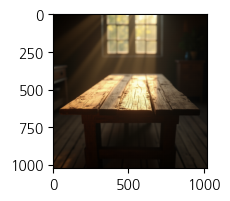

In [11]:
flush_gpu()
# Step 1: 배경 생성 (상품 없음)
background = flux_gen.generate_background(
    prompt=None,
    negative_prompt="banana, fruit, food, smooth surface, new wood",
    guidance_scale=3.5,
    seed=142,
    num_steps=num_steps, # 기본 25 테스트를 위하여 3회만
    progress_callback=progress_callback
)

if "flux_gen" in globals():
    del flux_gen
    flux_gen = None
    logger.debug("기존 flux_gen 인스턴스 삭제")

flush_gpu()
logger.debug("Background generated")
background.save("background.png")
    
plt.figure(figsize=(2, 2))
plt.imshow(background)

In [12]:
from models.qwen_vl_engine import QwenVLEngine
from models.qwen_vl_prompt import QwenVLPrompt
from utils import flush_gpu

# 엔진 한 번만 로드 (시간 소요)
engine = QwenVLEngine(
    model_id="Qwen/Qwen3-VL-8B-Instruct-FP8",
    device="cuda",
    gpu_memory_utilization=0.70
)

logger.debug("엔진 로드 완료! 이제 프롬프트만 바꿔가며 테스트할 수 있습니다.")

2026-01-04 13:06:54 I [qwen_vl_engine:51] - [QwenVLEngine] Initializing with model: Qwen/Qwen3-VL-8B-Instruct-FP8
INFO 01-04 04:06:57 [utils.py:253] non-default args: {'trust_remote_code': True, 'max_model_len': 8192, 'gpu_memory_utilization': 0.7, 'disable_log_stats': True, 'model': 'Qwen/Qwen3-VL-8B-Instruct-FP8'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
2026-01-04 04:07:00,059	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 01-04 04:07:00 [model.py:514] Resolved architecture: Qwen3VLForConditionalGeneration
INFO 01-04 04:07:00 [model.py:1661] Using max model len 8192
INFO 01-04 04:07:00 [scheduler.py:230] Chunked prefill is enabled with max_num_batched_tokens=8192.
(EngineCore_DP0 pid=1117188) INFO 01-04 04:07:18 [core.py:93] Initializing a V1 LLM engine (v0.13.0) with config: model='Qwen/Qwen3-VL-8B-Instruct-FP8', speculative_config=None, tokenizer='Qwen/Qwen3-VL-8B-Instruct-FP8', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=fp8, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=Fals

(EngineCore_DP0 pid=1117188) /home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/tvm_ffi/_optional_torch_c_dlpack.py:174: UserWarning: Failed to JIT torch c dlpack extension, EnvTensorAllocator will not be enabled.
(EngineCore_DP0 pid=1117188) We recommend installing via `pip install torch-c-dlpack-ext`
(EngineCore_DP0 pid=1117188)   warnings.warn(


(EngineCore_DP0 pid=1117188) INFO 01-04 04:07:34 [cuda.py:351] Using FLASH_ATTN attention backend out of potential backends: ('FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION')


Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:20<00:20, 20.72s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:42<00:00, 21.54s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:42<00:00, 21.41s/it]
(EngineCore_DP0 pid=1117188) 


(EngineCore_DP0 pid=1117188) INFO 01-04 04:08:18 [default_loader.py:308] Loading weights took 43.02 seconds
(EngineCore_DP0 pid=1117188) INFO 01-04 04:08:33 [gpu_model_runner.py:3659] Model loading took 10.3137 GiB memory and 52.523462 seconds
(EngineCore_DP0 pid=1117188) INFO 01-04 04:08:33 [gpu_model_runner.py:4446] Encoder cache will be initialized with a budget of 16384 tokens, and profiled with 1 image items of the maximum feature size.
(EngineCore_DP0 pid=1117188) INFO 01-04 04:09:00 [backends.py:643] Using cache directory: /home/spai0433/.cache/vllm/torch_compile_cache/5facaa2e4b/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=1117188) INFO 01-04 04:09:00 [backends.py:703] Dynamo bytecode transform time: 17.00 s
(EngineCore_DP0 pid=1117188) WARNING 01-04 04:09:09 [fp8_utils.py:1027] Using default W8A8 Block FP8 kernel config. Performance might be sub-optimal! Config file not found at /home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/vllm/model_e

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 51/51 [00:06<00:00,  8.49it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 35/35 [00:03<00:00,  9.36it/s]


(EngineCore_DP0 pid=1117188) INFO 01-04 04:09:25 [gpu_model_runner.py:4587] Graph capturing finished in 11 secs, took 0.66 GiB
(EngineCore_DP0 pid=1117188) INFO 01-04 04:09:25 [core.py:259] init engine (profile, create kv cache, warmup model) took 52.20 seconds
INFO 01-04 04:09:26 [llm.py:360] Supported tasks: ['generate']
2026-01-04 13:09:26 I [qwen_vl_engine:71] - [QwenVLEngine] Model loaded successfully
2026-01-04 13:09:26 D [config:12] - 엔진 로드 완료! 이제 프롬프트만 바꿔가며 테스트할 수 있습니다.


In [13]:
"""
QwenVL Prompt - Prompt management and message construction
프롬프트 관리 및 메시지 생성을 담당하는 클래스
"""

import os
import json
import re
import logging
import tempfile
from typing import List, Dict, Any, Optional, Tuple
from PIL import Image, ImageDraw, ImageFont
from helper_dev_utils import get_auto_logger

logger = get_auto_logger()


class QwenVLPrompt:
    """
    Qwen VL 프롬프트 관리 클래스

    프롬프트 템플릿을 관리하고 메시지를 생성합니다.
    엔진을 주입받아 추론을 실행할 수 있습니다.
    """

    def __init__(self, engine=None):
        """
        QwenVL 프롬프트 초기화

        Args:
            engine (QwenVLEngine, optional): QwenVL 엔진 인스턴스
        """
        self.engine = engine
        logger.info("[QwenVLPrompt] Initialized")

    def set_engine(self, engine):
        """
        엔진 설정

        Args:
            engine (QwenVLEngine): QwenVL 엔진 인스턴스
        """
        self.engine = engine
        logger.info("[QwenVLPrompt] Engine set successfully")

    def _save_image_to_temp(self, image: Image.Image) -> str:
        """
        이미지를 임시 파일로 저장하고 경로 반환

        Args:
            image (Image.Image): PIL 이미지

        Returns:
            str: 임시 파일 경로
        """
        temp_file = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
        image.save(temp_file.name)
        return temp_file.name

    def _cleanup_temp_file(self, file_path: str):
        """
        임시 파일 정리

        Args:
            file_path (str): 삭제할 파일 경로
        """
        if os.path.exists(file_path):
            os.remove(file_path)

    def _parse_json_response(self, raw_text: str, default_value: dict = None) -> dict:
        """
        모델 응답에서 JSON 추출 및 파싱

        Args:
            raw_text (str): 모델의 원시 출력
            default_value (dict, optional): 파싱 실패 시 기본값

        Returns:
            dict: 파싱된 JSON 딕셔너리
        """
        if default_value is None:
            default_value = {}

        try:
            # ```json ... ``` 패턴 제거
            json_match = re.search(r"```json\s*(\{.*?\})\s*```", raw_text, re.DOTALL)
            if json_match:
                clean_json_str = json_match.group(1)
            else:
                # 중괄호만 추출
                json_match = re.search(r"(\{.*\})", raw_text, re.DOTALL)
                clean_json_str = json_match.group(1) if json_match else raw_text

            result_dict = json.loads(clean_json_str)
            return result_dict

        except (json.JSONDecodeError, AttributeError) as e:
            logger.warning(
                f"[QwenVLPrompt] JSON Parse Error: {e}. Raw: {raw_text[:100]}..."
            )
            return default_value

    # ===== 프롬프트 템플릿 메서드 =====

    def create_text_position_prompt(self, image: Image.Image) -> List[Dict[str, Any]]:
        """
        텍스트 배치 위치 추천 프롬프트 생성

        Args:
            image (Image.Image): 분석할 이미지

        Returns:
            list: 메시지 리스트
        """
        temp_path = self._save_image_to_temp(image)

        prompt = """Analyze this image and recommend the best position to place text overlay.
Consider the following factors:
1. Empty space availability
2. Visual balance and composition
3. Contrast for text readability
4. Avoid covering important subjects

Respond in JSON format:
{
    "recommended_position": "top|center|bottom|left|right",
    "reasoning": "Explain why this position is best",
    "confidence": 0.0-1.0,
    "alternative_positions": ["position1", "position2"]
}"""

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": temp_path},
                    {"type": "text", "text": prompt},
                ],
            }
        ]

        return messages, temp_path

    def create_text_detection_prompt(self, image: Image.Image) -> List[Dict[str, Any]]:
        """
        텍스트 감지 (OCR) 프롬프트 생성

        Args:
            image (Image.Image): 분석할 이미지

        Returns:
            list: 메시지 리스트
        """
        temp_path = self._save_image_to_temp(image)

        prompt = """Detect all text in the image.
Return bounding boxes for each text region in [xmin, ymin, xmax, ymax] format (0-1000).

Respond in JSON format:
{
    "has_text": true/false,
    "text_content": "All detected text concatenated",
    "text_locations": [
        {"text": "word1", "bbox": [xmin, ymin, xmax, ymax]},
        {"text": "word2", "bbox": [xmin, ymin, xmax, ymax]}
    ],
    "description": "Brief description of text locations"
}"""

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": temp_path},
                    {"type": "text", "text": prompt},
                ],
            }
        ]

        return messages, temp_path

    def create_object_detection_prompt(
        self,
        image: Image.Image,
        target_object: str,
        negative_prompt: Optional[str] = None,
    ) -> List[Dict[str, Any]]:
        """
        객체 탐지 프롬프트 생성

        Args:
            image (Image.Image): 분석할 이미지
            target_object (str): 탐지할 객체
            negative_prompt (str, optional): 제외할 대상

        Returns:
            list: 메시지 리스트
        """
        temp_path = self._save_image_to_temp(image)

        # 기본 지시사항
        base_instruction = (
            f"Detect the '{target_object}' in this image. "
            f"Focus on the main object as described. "
            f"If found, return the bounding box in [xmin, ymin, xmax, ymax] format (scaled 0-1000)."
        )

        # 네거티브 프롬프트 추가
        if negative_prompt:
            base_instruction += (
                f"\n\n[Negative Constraint]: Do NOT detect, include, or focus on the following elements: {negative_prompt}. "
                f"Strictly exclude these from the bounding box."
            )

        # JSON 포맷 강제
        base_instruction += (
            "\n\nRespond ONLY in the following JSON format:\n"
            "{\n"
            '    "found": true/false,\n'
            f'    "object_name": "{target_object}",\n'
            '    "bbox": [xmin, ymin, xmax, ymax],\n'
            '    "confidence": 0.0-1.0,\n'
            '    "description": "Brief description of the detected region"\n'
            "}"
        )

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": temp_path},
                    {"type": "text", "text": base_instruction},
                ],
            }
        ]

        return messages, temp_path

    def create_custom_prompt(
        self, image: Image.Image, custom_text: str
    ) -> List[Dict[str, Any]]:
        """
        커스텀 프롬프트 생성

        Args:
            image (Image.Image): 분석할 이미지
            custom_text (str): 사용자 정의 프롬프트

        Returns:
            list: 메시지 리스트
        """
        temp_path = self._save_image_to_temp(image)

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": temp_path},
                    {"type": "text", "text": custom_text},
                ],
            }
        ]

        return messages, temp_path
    
    def create_all_objects_detection_prompt(
        self, image: Image.Image
    ) -> Tuple[List[Dict[str, Any]], str]:
        """
        [신규] 모든 객체 탐지용 프롬프트 생성
        """
        temp_path = self._save_image_to_temp(image)

        base_instruction = (
            "Detect all salient and distinct objects in this image. "
            "Ignore background clutter and very small details. "
            "Return the bounding boxes in [xmin, ymin, xmax, ymax] format (scaled 0-1000)."
            "\n\nRespond ONLY in the following JSON format:\n"
            "{\n"
            '    "objects": [\n'
            "        {\n"
            '            "object_name": "name of the object",\n'
            '            "bbox": [xmin, ymin, xmax, ymax],\n'
            '            "confidence": 0.0-1.0\n'
            "        },\n"
            "        ... more objects\n"
            "    ]\n"
            "}"
        )

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": temp_path},
                    {"type": "text", "text": base_instruction},
                ],
            }
        ]

        return messages, temp_path    

    # ===== 추론 실행 메서드 (엔진 필요) =====

    def analyze_text_position(
        self, image: Image.Image, max_tokens: int = 512, temperature: float = 0.0
    ) -> dict:
        """
        텍스트 배치 위치 분석

        Args:
            image (Image.Image): 분석할 이미지
            max_tokens (int): 최대 토큰 수
            temperature (float): 샘플링 온도

        Returns:
            dict: 분석 결과
        """
        if self.engine is None:
            raise ValueError("[QwenVLPrompt] Engine not set. Call set_engine() first.")

        messages, temp_path = self.create_text_position_prompt(image)

        try:
            raw_result = self.engine.run_inference(messages, max_tokens, temperature)

            result_dict = self._parse_json_response(
                raw_result,
                {
                    "recommended_position": "top",
                    "reasoning": "Failed to parse model output",
                    "confidence": 0.5,
                    "alternative_positions": ["center", "bottom"],
                },
            )

            return copy.deepcopy(result_dict)

        finally:
            self._cleanup_temp_file(temp_path)

    def find_text_regions(
        self, image: Image.Image, max_tokens: int = 1024, temperature: float = 0.0
    ) -> dict:
        """
        텍스트 감지 (OCR)

        Args:
            image (Image.Image): 분석할 이미지
            max_tokens (int): 최대 토큰 수
            temperature (float): 샘플링 온도

        Returns:
            dict: 감지 결과
        """
        if self.engine is None:
            raise ValueError("[QwenVLPrompt] Engine not set. Call set_engine() first.")

        messages, temp_path = self.create_text_detection_prompt(image)
        try:
            raw_result = self.engine.run_inference(messages, max_tokens, temperature)

            result_dict = self._parse_json_response(
                raw_result,
                {
                    "has_text": False,
                    "text_content": "",
                    "text_locations": [],
                    "description": "Failed to parse model output",
                },
            )

            return copy.deepcopy(result_dict)

        finally:
            self._cleanup_temp_file(temp_path)

    def detect_objects(
        self,
        image: Image.Image,
        target_object: str,
        negative_prompt: Optional[str] = None,
        max_tokens: int = 512,
        temperature: float = 0.01,
    ) -> dict:
        """
        객체 탐지

        Args:
            image (Image.Image): 분석할 이미지
            target_object (str): 탐지할 객체
            negative_prompt (str, optional): 제외할 대상
            max_tokens (int): 최대 토큰 수
            temperature (float): 샘플링 온도

        Returns:
            dict: 탐지 결과
        """
        if self.engine is None:
            raise ValueError("[QwenVLPrompt] Engine not set. Call set_engine() first.")

        messages, temp_path = self.create_object_detection_prompt(
            image, target_object, negative_prompt
        )

        try:
            raw_result = self.engine.run_inference(messages, max_tokens, temperature)

            result_dict = self._parse_json_response(
                raw_result,
                {
                    "found": False,
                    "object_name": target_object,
                    "bbox": [0, 0, 0, 0],
                    "confidence": 0.0,
                    "description": f"Parsing Error. Raw: {raw_result[:100]}...",
                },
            )
            
            if "bbox" in result_dict and len(result_dict["bbox"]) == 4:
                result_dict["img_bbox"] = self.image_pix_normalized_bbox(image, result_dict["bbox"])

            return copy.deepcopy(result_dict)

        finally:
            self._cleanup_temp_file(temp_path)

    def detect_all_objects(
        self,
        image: Image.Image,
        max_tokens: int = 1024,
        temperature: float = 0.2,
    ) -> List[Dict[str, Any]]:
        """
        이미지 내의 모든 주요 객체를 탐지하여 리스트로 반환합니다.

        Returns:
            List[Dict]: [
                {"object_name": "cat", "bbox": [100, 200, 300, 400], "confidence": 0.9},
                {"object_name": "table", "bbox": [500, 200, 800, 900], "confidence": 0.8},
                ...
            ]
        """
        if self.engine is None:
            raise ValueError("[QwenVLPrompt] Engine not set.")

        messages, temp_path = self.create_all_objects_detection_prompt(image)

        try:
            raw_result = self.engine.run_inference(messages, max_tokens, temperature)

            try:
                clean_json = raw_result.strip()
                if "```json" in clean_json:
                    clean_json = clean_json.split("```json")[1].split("```")[0].strip()
                elif "```" in clean_json:
                    clean_json = clean_json.split("```")[1].split("```")[0].strip()

                parsed = json.loads(clean_json)

                if "objects" in parsed and isinstance(parsed["objects"], list):
                    for obj in parsed["objects"]:
                        if "bbox" in obj and len(obj["bbox"]) == 4:
                            obj["img_bbox"] = self.image_pix_normalized_bbox(image, obj["bbox"])
                    return copy.deepcopy(parsed["objects"])
                else:
                    return []

            except (json.JSONDecodeError, KeyError) as e:
                logger.warning(f"Parsing Failed: {e}. Raw: {raw_result}")
                return []

        finally:
            self._cleanup_temp_file(temp_path)

    def recommend_object_placement(
        self,
        background: Image.Image,
        object_image: Image.Image,
        object_description: str = "product",
        placement_hint: Optional[str] = None,
        max_tokens: int = 512,
        temperature: float = 0.05  # 0.1 → 0.05로 변경
    ) -> dict:
        """배경 이미지에 오브젝트를 배치할 최적 위치 추천"""
        if self.engine is None:
            raise ValueError("[QwenVLPrompt] Engine not set. Call set_engine() first.")

        bg_temp_path = self._save_image_to_temp(background)
        obj_temp_path = self._save_image_to_temp(object_image)

        try:
            obj_w, obj_h = object_image.size
            bg_w, bg_h = background.size

            hint_instruction = ""
            if placement_hint:
                hint_instruction = f"""
**CRITICAL PLACEMENT CONSTRAINT**:
The object MUST be placed '{placement_hint}'.
This is the PRIMARY requirement that overrides all other considerations.

Step-by-step reasoning:
1. First, identify the reference location (window, table edge, etc.) mentioned in the hint
2. Then, find a physically stable surface (table, floor) near that location
3. Place the object on that surface, ensuring it is close to the reference location
4. The object must be ON a surface, NOT floating in air or overlapping with walls/windows
"""

            prompt_text = f"""Analyze the background image and recommend the best placement position for the '{object_description}' object.
{hint_instruction}

**Physical Realism Rules** (MANDATORY):
- The object MUST rest on a horizontal surface (table, floor, shelf)
- The object CANNOT float in mid-air
- The object CANNOT overlap with vertical surfaces (walls, windows)
- Gravity applies: bottom of bbox must touch the surface

**Evaluation Criteria** (in priority order):
1. **Placement hint compliance** (if provided): {placement_hint or 'not provided'}
2. Natural placement surface availability
3. Empty space for the object
4. Visual composition and balance
5. Object size compatibility ({obj_w}x{obj_h} px)

Background dimensions: {bg_w}x{bg_h} px

Return the bounding box in [xmin, ymin, xmax, ymax] format (0-1000 scale).
Ensure ymax is close to the surface level (table/floor y-coordinate).

Respond ONLY in this JSON format:
{{
    "bbox": [xmin, ymin, xmax, ymax],
    "placement_surface": "table|floor|shelf|...",
    "description": "Step-by-step explanation of placement decision",
    "confidence": 0.0-1.0
}}"""

            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "Background image:"},
                        {"type": "image", "image": bg_temp_path},
                        {"type": "text", "text": f"Object to place ({object_description}):"},
                        {"type": "image", "image": obj_temp_path},
                        {"type": "text", "text": prompt_text},
                    ],
                }
            ]

            raw_result = self.engine.run_inference(messages, max_tokens, temperature)

            result_dict = self._parse_json_response(
                raw_result,
                {
                    "bbox": [400, 600, 600, 800],
                    "placement_surface": "table",
                    "description": "Failed to parse model output. Using default center-bottom position.",
                    "confidence": 0.3,
                },
            )

            if "bbox" in result_dict and len(result_dict["bbox"]) == 4:
                result_dict["img_bbox"] = self.image_pix_normalized_bbox(background, result_dict["bbox"])

            hint_msg = f" (hint: {placement_hint})" if placement_hint else ""
            logger.info(f"[QwenVLPrompt] Object placement: {result_dict['placement_surface']}{hint_msg} (confidence: {result_dict.get('confidence', 0):.2f})")

            return copy.deepcopy(result_dict)

        finally:
            self._cleanup_temp_file(bg_temp_path)
            self._cleanup_temp_file(obj_temp_path)


    def run_custom_prompt(
        self,
        image: Image.Image,
        custom_text: str,
        max_tokens: int = 1024,
        temperature: float = 0.0,
    ) -> str:
        """
        커스텀 프롬프트 실행

        Args:
            image (Image.Image): 분석할 이미지
            custom_text (str): 사용자 정의 프롬프트
            max_tokens (int): 최대 토큰 수
            temperature (float): 샘플링 온도

        Returns:
            str: 모델 출력 (원시 텍스트)
        """
        if self.engine is None:
            raise ValueError("[QwenVLPrompt] Engine not set. Call set_engine() first.")

        messages, temp_path = self.create_custom_prompt(image, custom_text)

        try:
            raw_result = self.engine.run_inference(messages, max_tokens, temperature)
            return raw_result

        finally:
            self._cleanup_temp_file(temp_path)
            
    def image_pix_normalized_bbox(
        self,
        image: Image.Image,
        bbox_norm: List[float],
    ) -> Tuple[int, int, int, int]:
        """
        정규화된 바운딩박스를 이미지 pix로 변환 합니다.
        정규화된 좌표 -> 픽셀 좌표 변환

        Args:
            image (Image.Image): 원본 이미지
            bbox_norm (List[float]): [xmin, ymin, xmax, ymax] (0-1000)
        Returns:
            Tuple: pixel bbox
        """
        w, h = image.size
        xmin, ymin, xmax, ymax = bbox_norm

        x1 = (xmin / 1000.0) * w
        y1 = (ymin / 1000.0) * h
        x2 = (xmax / 1000.0) * w
        y2 = (ymax / 1000.0) * h

        return int(x1), int(y1), int(x2), int(y2)
            
    def image_normalized_bbox(
        self,
        image: Image.Image,
        bbox_norm: List[float],
        box_color: str = "red",
        box_width: int = 3,
        label: Optional[str] = None,
    ) -> Image.Image:
        """
        정규화된 바운딩박스를 이미지에 그려서 시각화합니다.

        Args:
            image (Image.Image): 원본 이미지
            bbox_norm (List[float]): [xmin, ymin, xmax, ymax] (0-1000)
            box_color (str): 박스 색상
            box_width (int): 박스 두께
            label (str, optional): 박스 라벨

        Returns:
            Image.Image: 바운딩박스가 그려진 이미지
        """
        img = image.convert("RGBA").copy()
        draw = ImageDraw.Draw(img)

        x1, y1, x2, y2 = self.image_pix_normalized_bbox(image, bbox_norm)

        logger.debug(f"[QwenVLPrompt] Drawing box: ({x1}, {y1}), ({x2}, {y2}) Color: {box_color} Label: {label}")

        draw.rectangle([x1, y1, x2, y2], outline=box_color, width=box_width)

        if label:
            draw.text((x1, max(y1 - 14, 0)), label, fill=box_color)

        return img.convert("RGB")
    
    def draw_detection_boxes(self, background: Image.Image, detections: List[Dict[str, Any]], box_color: str = "red", box_width: int = 4, font_size: int = 20) -> Image.Image:
        """
        배경 이미지에 detection 리스트의 bbox와 object_name을 그려 반환합니다.
        bbox 포맷: [xmin, ymin, xmax, ymax] (스케일 0-1000)
        """
        if isinstance(detections, dict):
            detections = [detections]

        w, h = background.size
        scale_x = w / 1000.0
        scale_y = h / 1000.0

        img = background.convert("RGBA").copy()
        draw = ImageDraw.Draw(img)
        font = ImageFont.load_default()

        for d in detections:
            bbox = d.get("bbox", [0, 0, 0, 0])
            xmin, ymin, xmax, ymax = [int(coord) for coord in bbox]
            box = (int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y))
            for i in range(box_width):
                rect = (box[0]-i, box[1]-i, box[2]+i, box[3]+i)
                draw.rectangle(rect, outline=box_color)
            label = f"{d.get('object_name','')} {d.get('confidence',0):.2f}"
            text_pos = (box[0] + 6, box[1] + 6)
            draw.text(text_pos, label, fill="white", font=font)

        logger.debug("draw_detection_boxes: rendered %d detections", len(detections))
        return img
    

prompt = QwenVLPrompt(engine=engine)
logger.debug("프롬프트 매니저 로드 완료")

2026-01-04 13:09:28 I [ipykernel_launcher:34] - [QwenVLPrompt] Initialized
2026-01-04 13:09:28 D [ipykernel_launcher:700] - 프롬프트 매니저 로드 완료


2026-01-04 13:09:29 D [qwen_vl_engine:88] - [QwenVLEngine] prompt: [{'role': 'user', 'content': [{'type': 'image', 'image': '/tmp/tmpu46mju1v.png'}, {'type': 'text', 'text': 'Detect all salient and distinct objects in this image. Ignore background clutter and very small details. Return the bounding boxes in [xmin, ymin, xmax, ymax] format (scaled 0-1000).\n\nRespond ONLY in the following JSON format:\n{\n    "objects": [\n        {\n            "object_name": "name of the object",\n            "bbox": [xmin, ymin, xmax, ymax],\n            "confidence": 0.0-1.0\n        },\n        ... more objects\n    ]\n}'}]}]
2026-01-04 13:09:29 D [qwen_vl_engine:89] - [QwenVLEngine] text: <|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Detect all salient and distinct objects in this image. Ignore background clutter and very small details. Return the bounding boxes in [xmin, ymin, xmax, ymax] format (scaled 0-1000).

Respond ONLY in the following JSON format:
{
    "objects": [
        

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it, est. speed input: 245.03 toks/s, output: 21.69 toks/s]

2026-01-04 13:09:52 D [qwen_vl_engine:157] - [QwenVLEngine] Generated output length: 290 chars
2026-01-04 13:09:52 I [helper_utils_print:588] - ├─ [0] [dict]
2026-01-04 13:09:52 I [helper_utils_print:443] - │  ├─ object_name [str]: wooden table
2026-01-04 13:09:52 I [helper_utils_print:389] - │  ├─ bbox [list]
2026-01-04 13:09:52 I [helper_utils_print:512] - │  │  ├─ [0] [int]: 41
2026-01-04 13:09:52 I [helper_utils_print:522] - │  │  ├─ ... (2 items omitted)
2026-01-04 13:09:52 I [helper_utils_print:577] - │  │  ├─ [3] [int]: 997
2026-01-04 13:09:52 I [helper_utils_print:443] - │  ├─ confidence [float]: 0.98
2026-01-04 13:09:52 I [helper_utils_print:389] - │  ├─ img_bbox [tuple]
2026-01-04 13:09:52 I [helper_utils_print:512] - │  │  ├─ [0] [int]: 41
2026-01-04 13:09:52 I [helper_utils_print:522] - │  │  ├─ ... (2 items omitted)
2026-01-04 13:09:52 I [helper_utils_print:577] - │  │  ├─ [3] [int]: 1020
2026-01-04 13:09:52 I [helper_utils_print:588] - ├─ [1] [dict]
2026-01-04 13:09:52 I 

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

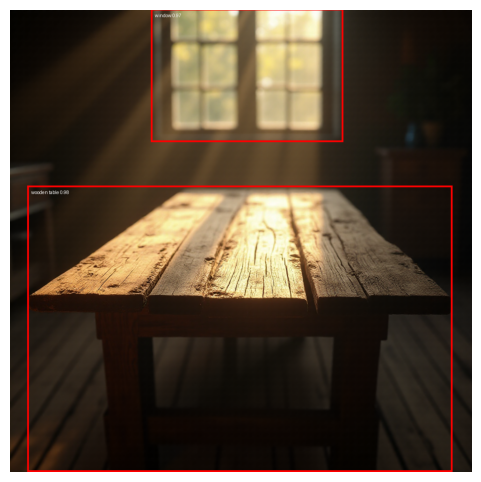

In [14]:
result = prompt.detect_all_objects(image=background)
print_dic_tree(result)
background_with_box = prompt.draw_detection_boxes(background, result)
plt.figure(figsize=(6,6)); plt.imshow(background_with_box); plt.axis("off")

2026-01-04 13:09:53 D [qwen_vl_engine:88] - [QwenVLEngine] prompt: [{'role': 'user', 'content': [{'type': 'image', 'image': '/tmp/tmpgtqbp6xa.png'}, {'type': 'text', 'text': 'Detect the \'wooden table\' in this image. Focus on the main object as described. If found, return the bounding box in [xmin, ymin, xmax, ymax] format (scaled 0-1000).\n\n[Negative Constraint]: Do NOT detect, include, or focus on the following elements: banana, fruit, food, smooth surface, new wood. Strictly exclude these from the bounding box.\n\nRespond ONLY in the following JSON format:\n{\n    "found": true/false,\n    "object_name": "wooden table",\n    "bbox": [xmin, ymin, xmax, ymax],\n    "confidence": 0.0-1.0,\n    "description": "Brief description of the detected region"\n}'}]}]
2026-01-04 13:09:53 D [qwen_vl_engine:89] - [QwenVLEngine] text: <|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Detect the 'wooden table' in this image. Focus on the main object as described. If found, return the bou

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 356.05 toks/s, output: 23.76 toks/s]

2026-01-04 13:09:56 D [qwen_vl_engine:157] - [QwenVLEngine] Generated output length: 261 chars
2026-01-04 13:09:56 I [helper_utils_print:443] - ├─ found [bool]: True
2026-01-04 13:09:56 I [helper_utils_print:443] - ├─ object_name [str]: wooden table
2026-01-04 13:09:56 I [helper_utils_print:389] - ├─ bbox [list]
2026-01-04 13:09:56 I [helper_utils_print:637] - │  ├─ [0] [int]: 41
2026-01-04 13:09:56 I [helper_utils_print:637] - │  ├─ [1] [int]: 383
2026-01-04 13:09:56 I [helper_utils_print:637] - │  ├─ [2] [int]: 955
2026-01-04 13:09:56 I [helper_utils_print:637] - │  ├─ [3] [int]: 997
2026-01-04 13:09:56 I [helper_utils_print:443] - ├─ confidence [float]: 0.98
2026-01-04 13:09:56 I [helper_utils_print:443] - ├─ description [str]: A rustic wooden table with visible grain and wear, illuminated by warm sunlight streaming through a ...
2026-01-04 13:09:56 I [helper_utils_print:389] - ├─ img_bbox [tuple]
2026-01-04 13:09:56 I [helper_utils_print:637] - │  ├─ [0] [int]: 41
2026-01-04 13:09:

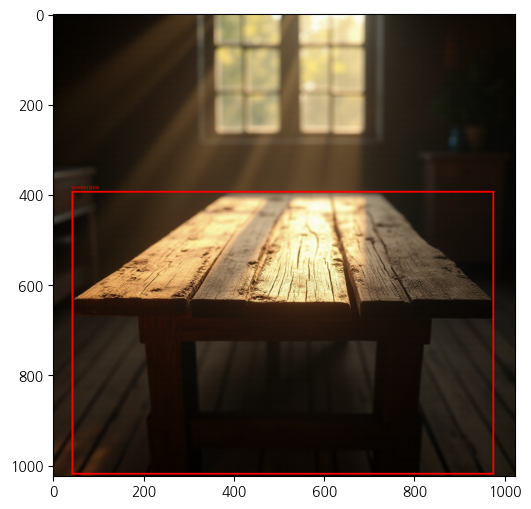

In [15]:
result = prompt.detect_objects(
    image = background,
    target_object = "wooden table",
    negative_prompt = "banana, fruit, food, smooth surface, new wood"
)

print_dic_tree(result, max_depth=100, list_count=100)

logger.debug("테스트 - 객체 탐지:")
logger.debug(f"  발견: {result['object_name']}")
logger.debug(f"  바운딩 박스: {result['bbox']}")
background_with_box = prompt.image_normalized_bbox(background, result['bbox'], box_color="red", box_width=4, label=result['object_name'])
plt.figure(figsize=(6, 6))
plt.imshow(background_with_box)

2026-01-04 13:09:58 D [qwen_vl_engine:88] - [QwenVLEngine] prompt: [{'role': 'user', 'content': [{'type': 'text', 'text': 'Background image:'}, {'type': 'image', 'image': '/tmp/tmpzgfp28p8.png'}, {'type': 'text', 'text': 'Object to place (product):'}, {'type': 'image', 'image': '/tmp/tmp41taznvw.png'}, {'type': 'text', 'text': 'Analyze the background image and recommend the best placement position for the \'product\' object.\n\n**CRITICAL PLACEMENT CONSTRAINT**:\nThe object MUST be placed \'on the table\'.\nThis is the PRIMARY requirement that overrides all other considerations.\n\nStep-by-step reasoning:\n1. First, identify the reference location (window, table edge, etc.) mentioned in the hint\n2. Then, find a physically stable surface (table, floor) near that location\n3. Place the object on that surface, ensuring it is close to the reference location\n4. The object must be ON a surface, NOT floating in air or overlapping with walls/windows\n\n\n**Physical Realism Rules** (MANDATORY

Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.08s/it, est. speed input: 322.92 toks/s, output: 21.56 toks/s]

2026-01-04 13:10:04 D [qwen_vl_engine:157] - [QwenVLEngine] Generated output length: 525 chars
2026-01-04 13:10:04 I [ipykernel_launcher:568] - [QwenVLPrompt] Object placement: table (hint: on the table) (confidence: 0.98)
2026-01-04 13:10:04 I [helper_utils_print:389] - ├─ bbox [list]
2026-01-04 13:10:04 I [helper_utils_print:637] - │  ├─ [0] [int]: 250
2026-01-04 13:10:04 I [helper_utils_print:637] - │  ├─ [1] [int]: 420
2026-01-04 13:10:04 I [helper_utils_print:637] - │  ├─ [2] [int]: 750
2026-01-04 13:10:04 I [helper_utils_print:637] - │  ├─ [3] [int]: 550
2026-01-04 13:10:04 I [helper_utils_print:443] - ├─ placement_surface [str]: table
2026-01-04 13:10:04 I [helper_utils_print:443] - ├─ description [str]: The banana is placed on the central part of the wooden table, which is the primary surface in the im...
2026-01-04 13:10:04 I [helper_utils_print:443] - ├─ confidence [float]: 0.98
2026-01-04 13:10:04 I [helper_utils_print:389] - ├─ img_bbox [tuple]
2026-01-04 13:10:04 I [helper

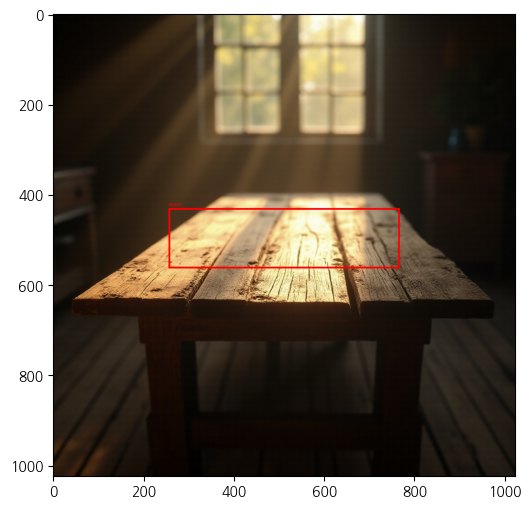

In [16]:
result_table = prompt.recommend_object_placement(background=background,
                                           object_image=image_png, 
                                           placement_hint="on the table")
print_dic_tree(result_table, max_depth=100, list_count=100)

background_with_box = prompt.image_normalized_bbox(background, result_table['bbox'], box_color="red", box_width=4, label='object')
plt.figure(figsize=(6, 6))
plt.imshow(background_with_box)

In [17]:
import ray
from utils import flush_gpu

flush_gpu()

if "engine" in globals() and engine is not None:
    del engine.llm
    del engine
    engine = None
    
    if ray.is_initialized():
        ray.shutdown()
        logger.debug("Ray 분산 환경 종료")
    
    flush_gpu()
    logger.debug("QwenVL 엔진 메모리 완전 해제 완료")

[rank0]:[W104 04:10:13.835837722 ProcessGroupNCCL.cpp:1524] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


2026-01-04 13:10:16 D [ipykernel_launcher:16] - QwenVL 엔진 메모리 완전 해제 완료


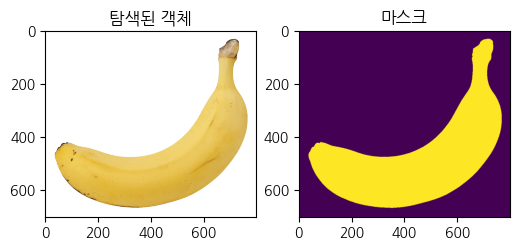

2026-01-04 13:10:17 I [helper_utils_print:389] - ├─ bbox [list]
2026-01-04 13:10:17 I [helper_utils_print:637] - │  ├─ [0] [int]: 250
2026-01-04 13:10:17 I [helper_utils_print:637] - │  ├─ [1] [int]: 420
2026-01-04 13:10:17 I [helper_utils_print:637] - │  ├─ [2] [int]: 750
2026-01-04 13:10:17 I [helper_utils_print:637] - │  ├─ [3] [int]: 550
2026-01-04 13:10:17 I [helper_utils_print:443] - ├─ placement_surface [str]: table
2026-01-04 13:10:17 I [helper_utils_print:443] - ├─ description [str]: The banana is placed on the central part of the wooden table, which is the primary surface in the im...
2026-01-04 13:10:17 I [helper_utils_print:443] - ├─ confidence [float]: 0.98
2026-01-04 13:10:17 I [helper_utils_print:389] - ├─ img_bbox [tuple]
2026-01-04 13:10:17 I [helper_utils_print:637] - │  ├─ [0] [int]: 256
2026-01-04 13:10:17 I [helper_utils_print:637] - │  ├─ [1] [int]: 430
2026-01-04 13:10:17 I [helper_utils_print:637] - │  ├─ [2] [int]: 768
2026-01-04 13:10:17 I [helper_utils_print:

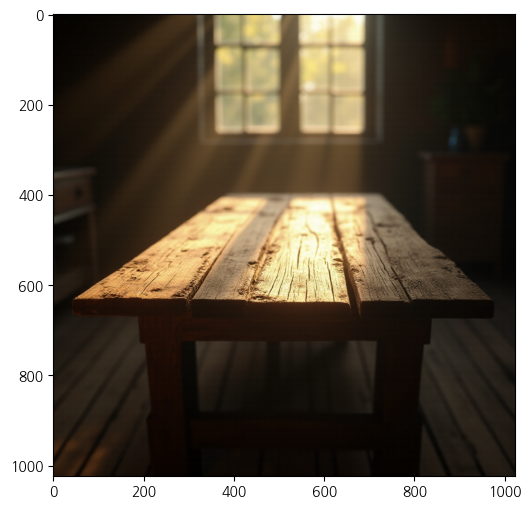

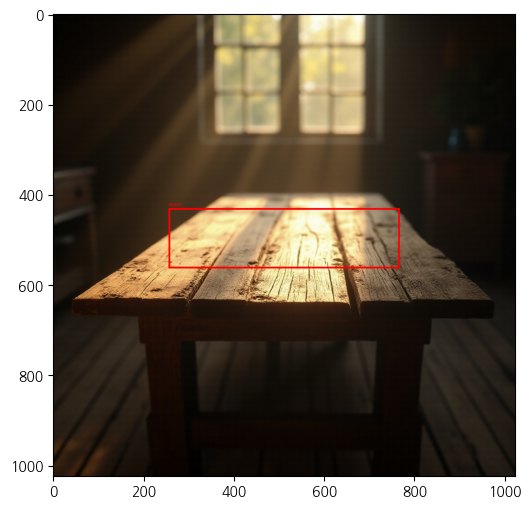

In [18]:
plt.figure(figsize=(6, 3))
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(sm_result)
ax1.set_title("탐색된 객체")

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(sm_mask)
ax2.set_title("마스크")
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(background)

plt.figure(figsize=(6, 6))
plt.imshow(background_with_box)

print_dic_tree(result_table, max_depth=100, list_count=100)

2026-01-04 13:10:18 D [ipykernel_launcher:2] - 로딩 성공
2026-01-04 13:10:18 I [helper_utils_print:389] - ├─ bbox [list]
2026-01-04 13:10:18 I [helper_utils_print:637] - │  ├─ [0] [int]: 250
2026-01-04 13:10:18 I [helper_utils_print:637] - │  ├─ [1] [int]: 420
2026-01-04 13:10:18 I [helper_utils_print:637] - │  ├─ [2] [int]: 750
2026-01-04 13:10:18 I [helper_utils_print:637] - │  ├─ [3] [int]: 550
2026-01-04 13:10:18 I [helper_utils_print:443] - ├─ placement_surface [str]: table
2026-01-04 13:10:18 I [helper_utils_print:443] - ├─ description [str]: The banana is placed on the central part of the wooden table, which is the primary surface in the im...
2026-01-04 13:10:18 I [helper_utils_print:443] - ├─ confidence [float]: 0.98
2026-01-04 13:10:18 I [helper_utils_print:389] - ├─ img_bbox [tuple]
2026-01-04 13:10:18 I [helper_utils_print:637] - │  ├─ [0] [int]: 256
2026-01-04 13:10:18 I [helper_utils_print:637] - │  ├─ [1] [int]: 430
2026-01-04 13:10:18 I [helper_utils_print:637] - │  ├─ [2] 

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

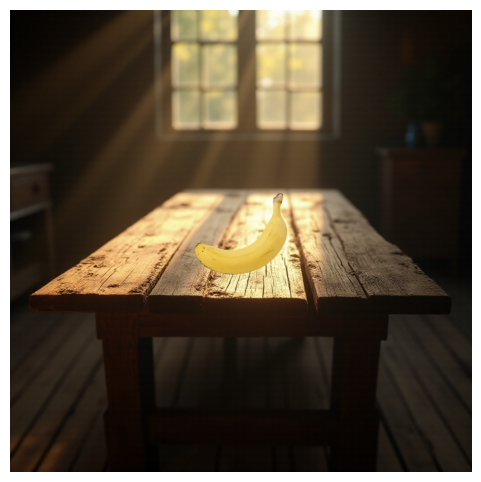

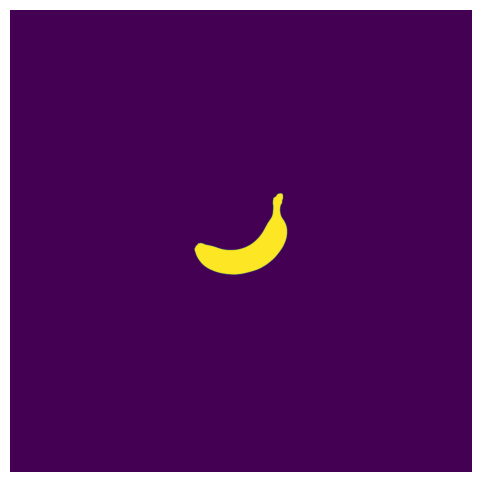

In [19]:
flux_gen = FluxGenerator()
logger.debug("로딩 성공")


# 공통 배경 요소 정의
# 공통 배경 요소
background_scene = "A cinematic photograph of an aged, empty wooden farm table resting in a sunlit room. Shafts of warm sunlight stream across the rough tabletop, revealing dust motes and deep textures. The wood is weathered and dark."
# → 영화적인 분위기의 사진, 햇살이 들어오는 방 안에 놓인 오래된 나무 농가 테이블
# → 따뜻한 햇살이 거친 테이블 표면을 가로질러 비추며 먼지 입자와 깊은 질감을 드러냄
# → 오래되어 바래고 어두운 색을 띠는 나무

background_style = "Shallow depth of field, highly detailed, rustic atmosphere, photorealistic, 8k."
# → 얕은 심도(배경 흐림, 테이블에 초점), 매우 디테일한 표현
# → 소박하고 시골스러운 분위기, 사진처럼 사실적인 표현
# → 초고해상도 8K 품질

# 공통 부정 요소
common_negative = "blurry, low quality, artificial, plastic, oversaturated, bad lighting"
# → 흐릿한, 저화질, 인위적인, 플라스틱 같은 질감
# → 과도하게 채도가 높은, 조명이 나쁜 표현은 배제

flux_gen.base_prompt(
    prompt=[
        background_scene,
        background_style
    ],
    negative=[
        common_negative
    ]
)

print_dic_tree(result_table, max_depth=100, list_count=100)

draft_rgb, full_mask =  flux_gen.prepare_inpaint_inputs(
    background=background, 
    product_foreground=sm_result, 
    product_mask=sm_mask,
    bbox=result_table['img_bbox'], 
    mask_dilation=-20, 
    padding_ratio = 1.5,
)

plt.figure(figsize=(6, 6))
plt.imshow(draft_rgb)
plt.axis("off")

plt.figure(figsize=(6, 6))
plt.imshow(full_mask)
plt.axis("off")


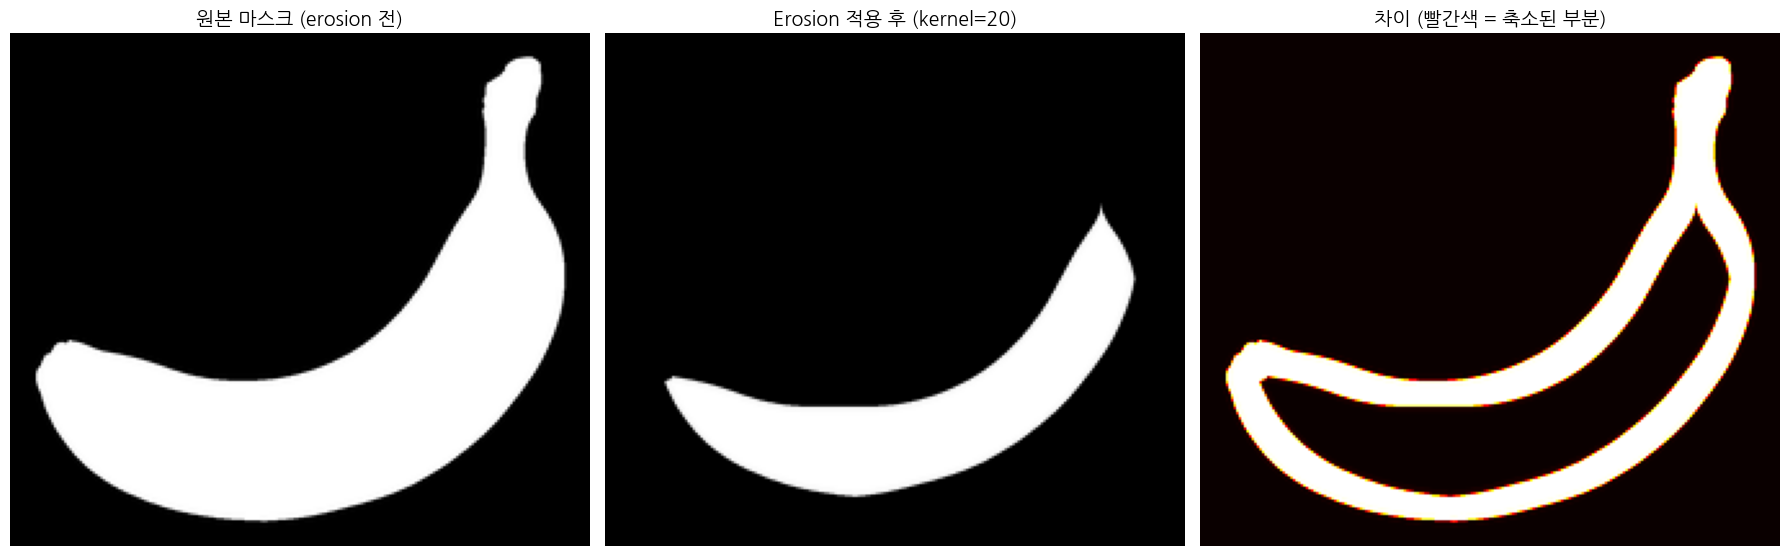

원본 마스크 픽셀 수: 13237
Erosion 후 픽셀 수: 6142
축소된 픽셀 수: 9278


In [20]:
# 🔍 마스크 erosion 전후 비교 디버깅
import cv2
import numpy as np

# 원본 마스크 (erosion 전)
x1, y1, x2, y2 = result_table['img_bbox']
bbox_w, bbox_h = x2 - x1, y2 - y1
obj_w, obj_h = sm_result.size
target_w = int(bbox_w * 1.5)
target_h = int(bbox_h * 1.5)
scale = min(target_w / obj_w, target_h / obj_h)
new_w, new_h = int(obj_w * scale), int(obj_h * scale)
resized_mask_original = sm_mask.resize((new_w, new_h), Image.LANCZOS)

# Erosion 적용 (-20)
mask_np = np.array(resized_mask_original)
kernel = np.ones((20, 20), np.uint8)
eroded_mask_np = cv2.erode(mask_np, kernel, iterations=1)
resized_mask_eroded = Image.fromarray(eroded_mask_np)

# 비교 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(resized_mask_original, cmap='gray')
axes[0].set_title('원본 마스크 (erosion 전)', fontsize=14)
axes[0].axis('off')

axes[1].imshow(resized_mask_eroded, cmap='gray')
axes[1].set_title('Erosion 적용 후 (kernel=20)', fontsize=14)
axes[1].axis('off')

# 차이 시각화
diff = np.array(resized_mask_original).astype(int) - np.array(resized_mask_eroded).astype(int)
axes[2].imshow(diff, cmap='hot')
axes[2].set_title('차이 (빨간색 = 축소된 부분)', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"원본 마스크 픽셀 수: {np.sum(np.array(resized_mask_original) > 128)}")
print(f"Erosion 후 픽셀 수: {np.sum(eroded_mask_np > 128)}")
print(f"축소된 픽셀 수: {np.sum(diff > 0)}")


2026-01-04 13:10:19 I [ipykernel_launcher:408] - [FluxGenerator] Loading FLUX Inpainting...


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-04 13:12:09 I [ipykernel_launcher:434] - [FluxGenerator] _promp='A ripe yellow banana placed on a table with natural contact shadow, seamlessly integrated into the surroundings in a realistic and harmonious way, photorealistic style, soft lighting, high detail A cinematic photograph of an aged, empty wooden farm table resting in a sunlit room. Shafts of warm sunlight stream across the rough tabletop, revealing dust motes and deep textures. The wood is weathered and dark. Shallow depth of field, highly detailed, rustic atmosphere, photorealistic, 8k.'
2026-01-04 13:12:09 I [ipykernel_launcher:435] - [FluxGenerator] _negative='blurry, low quality, artificial, plastic, oversaturated, bad lighting'
2026-01-04 13:12:09 I [ipykernel_launcher:436] - [FluxGenerator] strength=0.5, steps=28


Token indices sequence length is longer than the specified maximum sequence length for this model (100 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['is weathered and dark. shallow depth of field, highly detailed, rustic atmosphere, photorealistic, 8 k.']
  0%|          | 0/14 [00:00<?, ?it/s]/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


2026-01-04 13:13:08 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 1/28


  7%|▋         | 1/14 [00:04<00:55,  4.28s/it]

2026-01-04 13:13:10 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 2/28


 14%|█▍        | 2/14 [00:06<00:38,  3.23s/it]

2026-01-04 13:13:13 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 3/28


 21%|██▏       | 3/14 [00:09<00:31,  2.89s/it]

2026-01-04 13:13:15 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 4/28


 29%|██▊       | 4/14 [00:11<00:27,  2.73s/it]

2026-01-04 13:13:18 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 5/28


 36%|███▌      | 5/14 [00:14<00:23,  2.64s/it]

2026-01-04 13:13:20 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 6/28


 43%|████▎     | 6/14 [00:16<00:20,  2.59s/it]

2026-01-04 13:13:23 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 7/28


 50%|█████     | 7/14 [00:19<00:17,  2.55s/it]

2026-01-04 13:13:25 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 8/28


 57%|█████▋    | 8/14 [00:21<00:15,  2.53s/it]

2026-01-04 13:13:28 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 9/28


 64%|██████▍   | 9/14 [00:24<00:12,  2.52s/it]

2026-01-04 13:13:30 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 10/28


 71%|███████▏  | 10/14 [00:26<00:10,  2.51s/it]

2026-01-04 13:13:33 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 11/28


 79%|███████▊  | 11/14 [00:29<00:07,  2.50s/it]

2026-01-04 13:13:35 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 12/28


 86%|████████▌ | 12/14 [00:31<00:05,  2.50s/it]

2026-01-04 13:13:38 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 13/28


 93%|█████████▎| 13/14 [00:34<00:02,  2.50s/it]

2026-01-04 13:13:40 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 14/28


100%|██████████| 14/14 [00:36<00:00,  2.62s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-04 13:13:44 I [ipykernel_launcher:451] - [FluxGenerator] Feature injection completed


(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

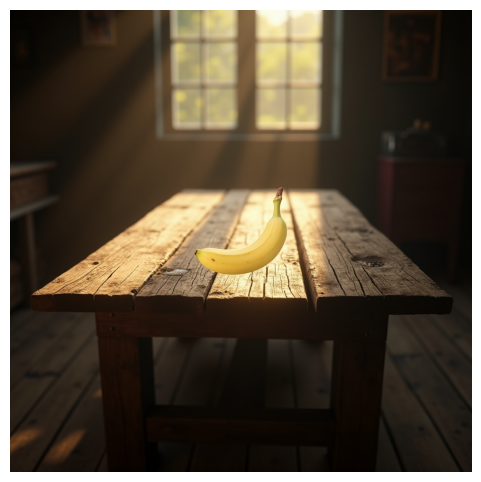

In [21]:
flush_gpu()
result = flux_gen.inject_features_via_inpaint(
    image=draft_rgb,
    mask_image=None,
    prompt="A ripe yellow banana placed on a table with natural contact shadow, seamlessly integrated into the surroundings in a realistic and harmonious way, photorealistic style, soft lighting, high detail",
    negative_prompt=None,
    strength=0.5,
    guidance_scale=3.5,
    seed=42,
    progress_callback=progress_callback
)
flush_gpu()

plt.figure(figsize=(6, 6))
plt.imshow(result)
plt.axis("off")

2026-01-04 15:07:52 I [ipykernel_launcher:408] - [FluxGenerator] Loading FLUX Inpainting...


Loading pipeline components...: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-04 15:09:59 I [ipykernel_launcher:434] - [FluxGenerator] _promp='A photorealistic image based on image_0.png, showing the ripe yellow banana firmly placed on the rustic wooden table surface. A dark, realistic, soft contact shadow is underneath the banana, anchoring it to the wood grain and following its curve, making it appear heavy and stable. Natural soft light from the window, high detail, seamless integration. A cinematic photograph of an aged, empty wooden farm table resting in a sunlit room. Shafts of warm sunlight stream across the rough tabletop, revealing dust motes and deep textures. The wood is weathered and dark. Shallow depth of field, highly detailed, rustic atmosphere, photorealistic, 8k.'
2026-01-04 15:09:59 I [ipykernel_launcher:435] - [FluxGenerator] _negative='blurry, low quality, artificial, plastic, oversaturated, bad lighting'
2026-01-04 15:09:59 I [ipykernel_launcher:436] - [FluxGenerator] strength=0.5, steps=28


Token indices sequence length is longer than the specified maximum sequence length for this model (135 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['an aged, empty wooden farm table resting in a sunlit room. shafts of warm sunlight stream across the rough tabletop, revealing dust motes and deep textures. the wood is weathered and dark. shallow depth of field, highly detailed, rustic atmosphere, photorealistic, 8 k.']
  0%|          | 0/14 [00:00<?, ?it/s]

2026-01-04 15:11:09 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 1/28


  7%|▋         | 1/14 [00:04<01:01,  4.74s/it]

2026-01-04 15:11:12 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 2/28


 14%|█▍        | 2/14 [00:07<00:42,  3.56s/it]

2026-01-04 15:11:14 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 3/28


 21%|██▏       | 3/14 [00:10<00:34,  3.13s/it]

2026-01-04 15:11:17 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 4/28


 29%|██▊       | 4/14 [00:12<00:29,  2.91s/it]

2026-01-04 15:11:20 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 5/28


 36%|███▌      | 5/14 [00:15<00:25,  2.81s/it]

2026-01-04 15:11:22 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 6/28


 43%|████▎     | 6/14 [00:18<00:22,  2.79s/it]

2026-01-04 15:11:25 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 7/28


 50%|█████     | 7/14 [00:20<00:18,  2.71s/it]

2026-01-04 15:11:28 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 8/28


 57%|█████▋    | 8/14 [00:23<00:15,  2.67s/it]

2026-01-04 15:11:30 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 9/28


 64%|██████▍   | 9/14 [00:25<00:13,  2.64s/it]

2026-01-04 15:11:33 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 10/28


 71%|███████▏  | 10/14 [00:28<00:10,  2.60s/it]

2026-01-04 15:11:35 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 11/28


 79%|███████▊  | 11/14 [00:30<00:07,  2.57s/it]

2026-01-04 15:11:38 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 12/28


 86%|████████▌ | 12/14 [00:33<00:05,  2.55s/it]

2026-01-04 15:11:40 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 13/28


 93%|█████████▎| 13/14 [00:35<00:02,  2.54s/it]

2026-01-04 15:11:43 D [ipykernel_launcher:4] - [Test Progress] flux_feature_injection: 14/28


100%|██████████| 14/14 [00:38<00:00,  2.74s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-04 15:11:46 I [ipykernel_launcher:451] - [FluxGenerator] Feature injection completed


(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

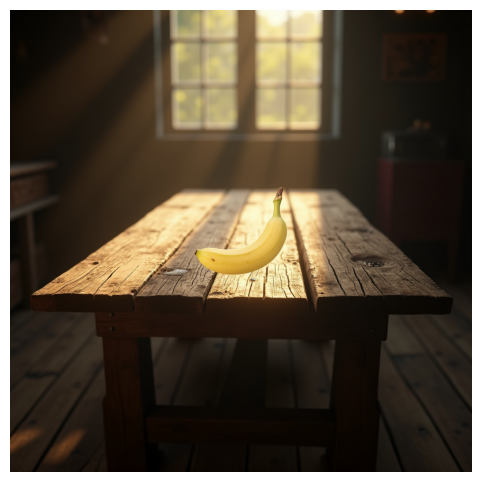

In [22]:
flush_gpu()
result = flux_gen.inject_features_via_inpaint(
    image=draft_rgb,
    mask_image=None,
    prompt="A photorealistic image based on image_0.png, showing the ripe yellow banana firmly placed on the rustic wooden table surface. A dark, realistic, soft contact shadow is underneath the banana, anchoring it to the wood grain and following its curve, making it appear heavy and stable. Natural soft light from the window, high detail, seamless integration.",
    negative_prompt=None,
    strength=0.5,
    guidance_scale=3.5,
    seed=42,
    progress_callback=progress_callback
)
flush_gpu()

plt.figure(figsize=(6, 6))
plt.imshow(result)
plt.axis("off")